## **BRAIN TUMOR CLASSIFICATION**
 Brain tumor is one of the major and critical health issue and it’s timely diagnosis is very crucial for patient’s life. Automated diagnosis of tumor can help doctors and patients to start the treatment timely. This project known as **BraTum scans** involves the classification of three different types of brain tumor like glioma tumor, meningioma tumor, pituitary tumor using **MobileNet-v2** model.

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import torch
torch.cuda.is_available()

True

# Getting important modules require for classifcation
i am using torchvision for getting desired model. tqdm library is used to show progress bars. other modules help to obtain the desired results.

In [ ]:
from google.colab import drive
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm.notebook import tqdm #for showing bars
import cv2
from torchvision.transforms import functional as F

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Mounting the google drive
necessary to mount google drive so that we can access the desired custom dataset from google drive we want to use for classification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Show function
This function is created to display ground truth and the model predicted value on test image. this will be used after training the model on training dataset.

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def show_images(image, probs, label_names, true_label):
    # Convert the PyTorch tensor image to NumPy format
    image = image.cpu().numpy().transpose(1, 2, 0)

    # Get the predicted label index and its corresponding probability
    predicted_label_idx = torch.argmax(probs).item()
    predicted_label_prob = probs[0, predicted_label_idx].item()

    # Get the label names for true and predicted labels
    true_label_name = label_names[true_label]
    predicted_label_name = label_names[predicted_label_idx]

    # Prepare the overlay text
    overlay_text = f'True Label: {true_label_name}\nPredicted: {predicted_label_name} ({predicted_label_prob:.2f})'

    # Display the image with the overlay text
    plt.imshow(image)
    plt.title(overlay_text, fontsize=12, color='white', backgroundcolor='grey')  # Customize title appearance
    plt.axis('off')
    plt.show()


# About data:
Data consist of three folders training dataset, testing dataset and validation dataset. Each further consist of four classes glioma_tumor, meningioma_tumor, no_tumor and pituitary tumor. training dataset contain 2285 images , validation set contain 652 while testing set contain 327 images.
(DATA augmentation---- i applied data augmentation when i divided the given four classes into further sub-classes i.e- top Angle, left Angle, back Angle).


In [ ]:
#to check number of images in testing and training set
# Replace 'path/to/testing_folder' and 'path/to/training_folder' with the actual paths to your testing and training folders
testing_folder_path = '/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/testing'
training_folder_path = '/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/Training'
validation_folder_path = '/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/validation'

def get_num_files_in_folder(folder_path):
    num_files = 0
    for dirpath, _, filenames in os.walk(folder_path):
        num_files += len(filenames)
    return num_files

# Get the number of files in the testing folder
testing_length = get_num_files_in_folder(testing_folder_path)
print(f"Number of files in testing folder: {testing_length}")

# Get the number of files in the training folder
training_length = get_num_files_in_folder(training_folder_path)
print(f"Number of files in training folder: {training_length}")

# Get the number of files in the validation folder
validation_length = get_num_files_in_folder(validation_folder_path)
print(f"Number of files in validation folder: {validation_length}")

Number of files in testing folder: 327
Number of files in training folder: 2285
Number of files in validation folder: 652


# Transform
declaring tranform according to Mobilenet-v2 model requirement. resizing images to 224X224 size and converting them into tensors.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224) for MobileNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Linking the dataset

In [ ]:
training='/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/Training'
testing='/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/testing'
validation= '/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/validation'

In [ ]:
test_dataset = ImageFolder(root=testing, transform=transform)

In [ ]:
train_dataset = ImageFolder(root=training, transform=transform)

In [ ]:
valid_dataset = ImageFolder(root=validation, transform=transform)

# calculating the number of images in each class in training set

In [ ]:
class_counts = {}
for class_name, class_idx in train_dataset.class_to_idx.items():
    class_folder_path = os.path.join(training, class_name)
    class_count = len(os.listdir(class_folder_path))
    class_counts[class_name] = class_count

# Print the number of images in each class folder
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'glioma_tumor': 648 images
Class 'meningioma_tumor': 656 images
Class 'no_tumor': 350 images
Class 'pituitary_tumor': 631 images


# calculating the number of images in each class in validation set

In [ ]:
class_counts = {}
for class_name, class_idx in test_dataset.class_to_idx.items():
    class_folder_path = os.path.join(testing, class_name)
    class_count = len(os.listdir(class_folder_path))
    class_counts[class_name] = class_count

# Print the number of images in each class folder
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'glioma_tumor': 93 images
Class 'meningioma_tumor': 94 images
Class 'no_tumor': 50 images
Class 'pituitary_tumor': 90 images


# calculating the number of images in each class in testing set

In [ ]:
class_counts = {}
for class_name, class_idx in valid_dataset.class_to_idx.items():
    class_folder_path = os.path.join(validation, class_name)
    class_count = len(os.listdir(class_folder_path))
    class_counts[class_name] = class_count

# Print the number of images in each class folder
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'glioma_tumor': 185 images
Class 'meningioma_tumor': 187 images
Class 'no_tumor': 100 images
Class 'pituitary_tumor': 180 images


# Visual respresentation
visual representation of data ranging in training, validation and testing set

In [ ]:
glimoa_train = os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/Training/glioma_tumor")
men_train =  os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/Training/meningioma_tumor")
notumor_train = os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/Training/no_tumor")
pit_train =  os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/Training/pituitary_tumor")

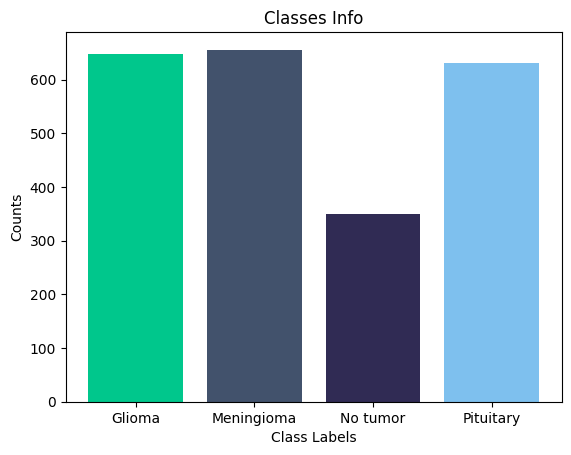

In [ ]:
import matplotlib.pyplot as plt

labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
values = [len(glimoa_train), len(men_train), len(notumor_train), len(pit_train)]

# Set the color palette for the bars
colors = ["#00C78C", "#42526C", "#302B54", "#7EC0EE"]

# Create the bar plot
plt.bar(labels, values, color=colors)

# Set the title and labels
plt.title('Classes Info')
plt.xlabel('Class Labels')
plt.ylabel('Counts')

# Show the plot
plt.show()

In [ ]:
glimoa_valid = os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/validation/glioma_tumor")
men_valid =  os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/validation/meningioma_tumor")
notumor_valid = os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/validation/no_tumor")
pit_valid =  os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/validation/pituitary_tumor")

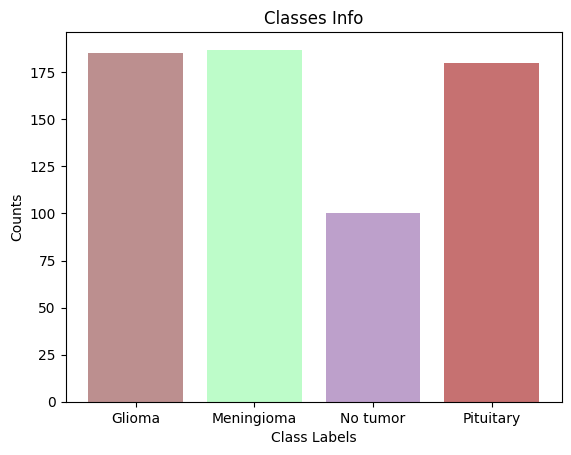

In [ ]:
labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
values = [len(glimoa_valid), len(men_valid), len(notumor_valid), len(pit_valid)]

# Set the color palette for the bars
colors = ["#BC8F8F", "#BDFCC9", "#BDA0CB", "#C67171"]

# Create the bar plot
plt.bar(labels, values, color=colors)

# Set the title and labels
plt.title('Classes Info')
plt.xlabel('Class Labels')
plt.ylabel('Counts')

# Show the plot
plt.show()

In [ ]:
glimoa_test = os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/testing/glioma_tumor")
men_test =  os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/testing/meningioma_tumor")
notumor_test = os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/testing/no_tumor")
pit_test =  os.listdir("/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/testing/pituitary_tumor")

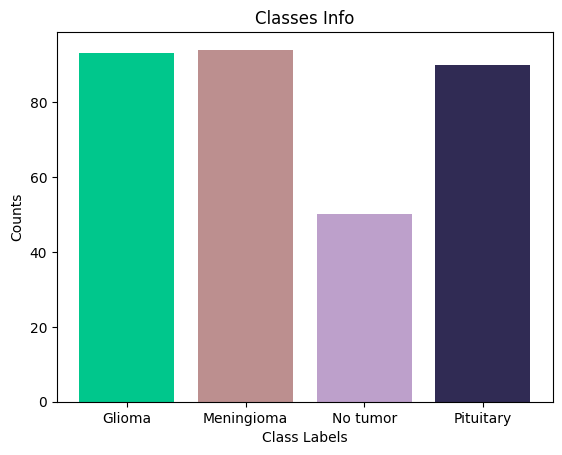

In [ ]:
labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
values = [len(glimoa_test), len(men_test), len(notumor_test), len(pit_test)]

# Set the color palette for the bars
colors = ["#00C78C", "#BC8F8F", "#BDA0CB", "#302B54"]

# Create the bar plot
plt.bar(labels, values, color=colors)

# Set the title and labels
plt.title('Classes Info')
plt.xlabel('Class Labels')
plt.ylabel('Counts')

# Show the plot
plt.show()

# Loading the data:
this step includes loading the data and declaring the batch size

In [ ]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Getting some information about datasets:

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([32, 3, 224, 224])

In [ ]:
a = next(iter(test_loader))
a[0].size()

torch.Size([32, 3, 224, 224])

In [ ]:
a = next(iter(valid_loader))
a[0].size()

torch.Size([32, 3, 224, 224])

# Displaying images:
displaying some of the images from training dataset for clear visual understanding of data.

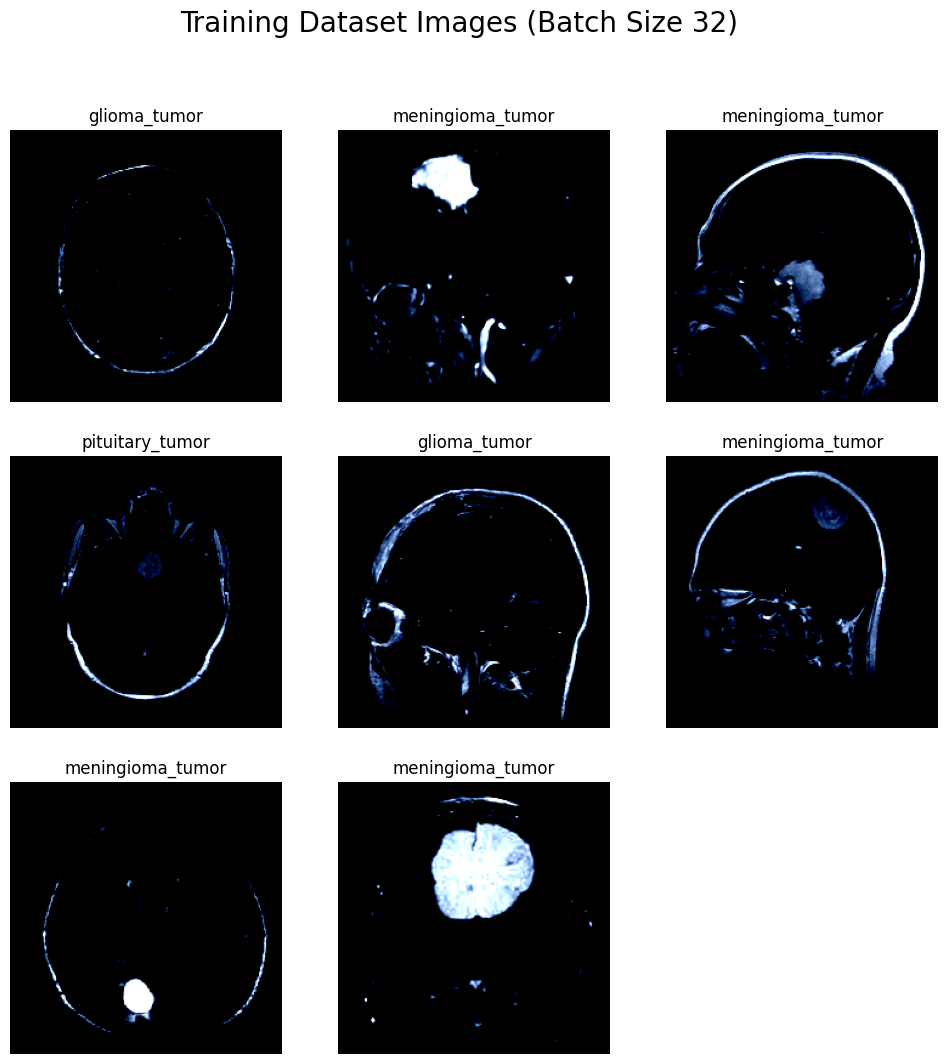

In [ ]:
import numpy as np
images, labels = next(iter(train_loader))

# Function to display a grid of images along with class names
def show_images_grid(images, labels, class_names, title):
    num_images = images.shape[0]
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    fig.suptitle(title, fontsize=20)

    for i, ax in enumerate(axes.ravel()):
        if i < num_images:
            image = images[i].permute(1, 2, 0)  # Change tensor shape (C, H, W) to (H, W, C)
            ax.imshow(image)
            ax.set_title(class_names[labels[i].item()])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

# List of class names in the dataset
class_names = train_dataset.classes

# Display the first 8 images from the batch with class names
show_images_grid(images[:8], labels[:8], class_names, "Training Dataset Images (Batch Size 32)")

# Number of Batches
Displaying number of batches in traing, validating and testing dataset while keeping batch size:32

In [ ]:
# Calculate the total number of batches for training dataset
total_train_batches = len(train_dataset) // batch_size
if len(train_dataset) % batch_size != 0:
    total_train_batches += 1

# Calculate the total number of batches for testing dataset
total_test_batches = len(test_dataset) // batch_size
if len(test_dataset) % batch_size != 0:
    total_test_batches += 1
# Calculate the total number of batches for validation dataset
total_valid_batches = len(valid_dataset) // batch_size
if len(valid_dataset) % batch_size != 0:
    total_valid_batches += 1


print(f"Total number of batches for training dataset: {total_train_batches}")
print(f"Total number of batches for testing dataset: {total_test_batches}")
print(f"Total number of batches for validation dataset: {total_valid_batches}")

Total number of batches for training dataset: 72
Total number of batches for testing dataset: 11
Total number of batches for validation dataset: 21


# working on GPU:
if gpu not avaialble then consume cpu resources.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Importing the model
importing the MobileNet-v2 model from torchvision.models.

In [ ]:
from torchvision.models import mobilenet_v2

In [ ]:
from torchvision.models import mobilenet_v2
num_classes = len(train_dataset.classes)
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)


In [ ]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Defining loss function and optimizer

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
loop for training the model on training dataset.

In [ ]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    corrects = 0

    for inputs, labels in tqdm(dataloader, total=len(dataloader), leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

    train_loss = train_loss / len(dataloader.dataset)
    train_acc = corrects.double() / len(dataloader.dataset)

    return train_loss, train_acc

# Validation loop
def validate(model, dataloader, criterion):
    model.eval()
    valid_loss = 0.0
    corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader), leave=True):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

    valid_loss = valid_loss / len(dataloader.dataset)
    valid_acc = corrects.double() / len(dataloader.dataset)

    return valid_loss, valid_acc

# Training and validation loop
num_epochs = 30
best_valid_loss = float('inf')
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = validate(model, valid_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")



Epoch 1/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.4305 | Train Acc: 0.8451
Valid Loss: 1.0248 | Valid Acc: 0.7301
Epoch 2/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.2309 | Train Acc: 0.9230
Valid Loss: 1.6095 | Valid Acc: 0.5982
Epoch 3/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.1355 | Train Acc: 0.9558
Valid Loss: 0.8141 | Valid Acc: 0.7837
Epoch 4/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.1082 | Train Acc: 0.9650
Valid Loss: 0.8305 | Valid Acc: 0.7883
Epoch 5/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.1021 | Train Acc: 0.9628
Valid Loss: 0.7586 | Valid Acc: 0.8344
Epoch 6/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0824 | Train Acc: 0.9724
Valid Loss: 0.7534 | Valid Acc: 0.8252
Epoch 7/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0704 | Train Acc: 0.9772
Valid Loss: 0.6974 | Valid Acc: 0.8543
Epoch 8/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.1203 | Train Acc: 0.9628
Valid Loss: 0.6915 | Valid Acc: 0.8528
Epoch 9/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0805 | Train Acc: 0.9733
Valid Loss: 0.6494 | Valid Acc: 0.8482
Epoch 10/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0260 | Train Acc: 0.9912
Valid Loss: 0.8262 | Valid Acc: 0.8666
Epoch 11/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0501 | Train Acc: 0.9829
Valid Loss: 0.9249 | Valid Acc: 0.8436
Epoch 12/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0502 | Train Acc: 0.9838
Valid Loss: 1.0418 | Valid Acc: 0.8466
Epoch 13/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0555 | Train Acc: 0.9869
Valid Loss: 0.7983 | Valid Acc: 0.8666
Epoch 14/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0603 | Train Acc: 0.9847
Valid Loss: 0.9978 | Valid Acc: 0.8374
Epoch 15/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0386 | Train Acc: 0.9895
Valid Loss: 1.0102 | Valid Acc: 0.8482
Epoch 16/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0284 | Train Acc: 0.9917
Valid Loss: 1.0018 | Valid Acc: 0.8420
Epoch 17/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0194 | Train Acc: 0.9961
Valid Loss: 1.1715 | Valid Acc: 0.8067
Epoch 18/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0355 | Train Acc: 0.9886
Valid Loss: 1.0182 | Valid Acc: 0.8696
Epoch 19/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0520 | Train Acc: 0.9856
Valid Loss: 1.1908 | Valid Acc: 0.8190
Epoch 20/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0721 | Train Acc: 0.9764
Valid Loss: 1.1278 | Valid Acc: 0.8359
Epoch 21/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0761 | Train Acc: 0.9812
Valid Loss: 0.6753 | Valid Acc: 0.8773
Epoch 22/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0715 | Train Acc: 0.9777
Valid Loss: 0.7383 | Valid Acc: 0.8466
Epoch 23/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0348 | Train Acc: 0.9886
Valid Loss: 1.3820 | Valid Acc: 0.7899
Epoch 24/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0346 | Train Acc: 0.9917
Valid Loss: 0.6497 | Valid Acc: 0.8727
Epoch 25/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0026 | Train Acc: 1.0000
Valid Loss: 0.9427 | Valid Acc: 0.8604
Epoch 26/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0016 | Train Acc: 1.0000
Valid Loss: 1.0822 | Valid Acc: 0.8558
Epoch 27/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Acc: 1.0000
Valid Loss: 1.0345 | Valid Acc: 0.8589
Epoch 28/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0049 | Train Acc: 0.9987
Valid Loss: 1.1502 | Valid Acc: 0.8620
Epoch 29/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0675 | Train Acc: 0.9807
Valid Loss: 1.3392 | Valid Acc: 0.8175
Epoch 30/30


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.0781 | Train Acc: 0.9755
Valid Loss: 1.0393 | Valid Acc: 0.8451


In [ ]:
from torchsummary import summary

In [ ]:
input_size = (3, 224, 224)  # Assuming 3 channels and input size of 224x224

# Print the summary
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
       BatchNorm2d-4         [-1, 32, 112, 112]              64
             ReLU6-5         [-1, 32, 112, 112]               0
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
            Conv2d-8         [-1, 32, 112, 112]             288
       BatchNorm2d-9         [-1, 32, 112, 112]              64
      BatchNorm2d-10         [-1, 32, 112, 112]              64
            ReLU6-11         [-1, 32, 112, 112]               0
            ReLU6-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
           Conv2d-14         [-1, 16, 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


# Displaying graphs
Displaying graphs for training and valiadation accuracy and loss.

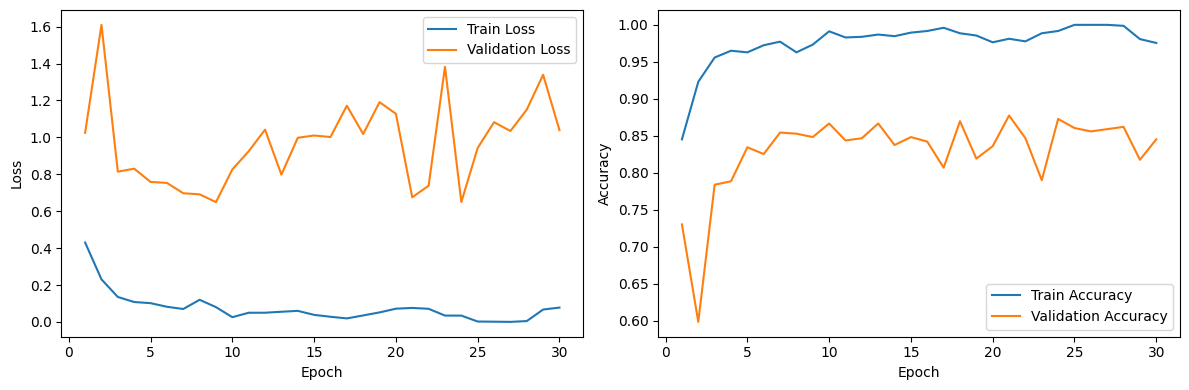

In [ ]:
train_accuracies_cpu = [acc.cpu().numpy() for acc in train_accuracies]
valid_accuracies_cpu = [acc.cpu().numpy() for acc in valid_accuracies]
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies_cpu, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Saving the model

In [ ]:
torch.save(model, '/content/drive/MyDrive/whole_data_30(mn4).pt')

# Loading the model

In [ ]:
!pip install torchcam

PIL to visualization and manipulation of images

In [ ]:
from PIL import Image

# Testing the model
loop for testing the trained model on testing dataset

In [ ]:
test_losses = []
test_accuracies = []

# Evaluate the model on testing data with tqdm progress bar
Model.eval()
correct_test = 0
total_test = 0
running_loss = 0.0
test_preds = []
test_labels = []
with torch.no_grad(), tqdm(test_loader, desc="Testing Batches", leave=False) as t:
    for inputs, labels in t:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = Model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted_test = torch.max(outputs.data, 1)
        test_preds.extend(predicted_test.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

        t.set_postfix({'Loss': running_loss / (t.n + 1)})

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)
    test_losses.append(running_loss / len(test_loader))

# Print the accuracy and loss for testing
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_losses[-1]:.4f}")


Testing Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Test Accuracy: 92.35%
Test Loss: 0.5679


# Displaying the tested images with labels:
Displaying the tested image with ground truth and predictied labels by model.

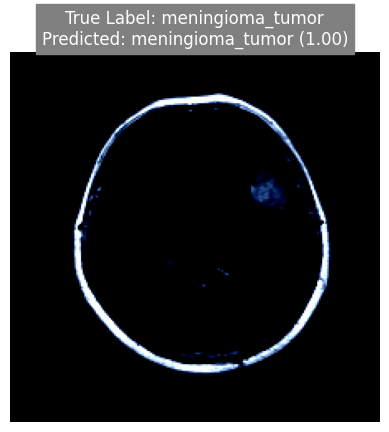

In [ ]:
image, label = test_dataset[100]

# Forward pass through the model
with torch.no_grad():
    ps = model(image.to(device).unsqueeze(0))
    ps = F.softmax(ps, dim=1)

# Define class labels (modify based on your dataset)
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Show the image with predicted probabilities for all classes
show_images(image, ps, class_labels, label)





# Getting classifcation report

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.88      0.91        93
meningioma_tumor       0.81      0.80      0.80        94
        no_tumor       0.86      1.00      0.93        50
 pituitary_tumor       0.91      0.90      0.91        90

        accuracy                           0.88       327
       macro avg       0.88      0.89      0.89       327
    weighted avg       0.88      0.88      0.88       327



# Getting Confusion Matrix

Confusion Matrix:

[[82  9  0  2]
 [ 5 75  8  6]
 [ 0  0 50  0]
 [ 0  9  0 81]]


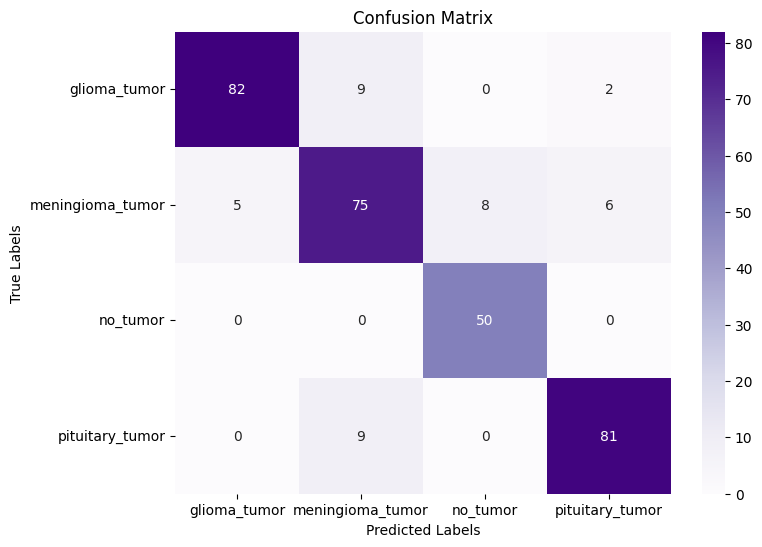

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ... (rest of the code for evaluation and generating test_preds and test_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Print the confusion matrix
print("Confusion Matrix:\n")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Explainable AI
Here, i am going to apply Explainable AI on my model to get deep understanding of how model captured and learned features during training. In the block below some of the important libraries are being installed. I am using Torchcam library for displaying the images with heat maps located on model's captured features.

In [ ]:
!pip install torchvision matplotlib
!pip install torchcam
!pip install -e git+https://github.com/frgfm/torch-cam.git#egg=torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.13.1 which

In [ ]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization
here, i loaded my pre-trained model and apply Grad-cam on few of the images from testing set.

1


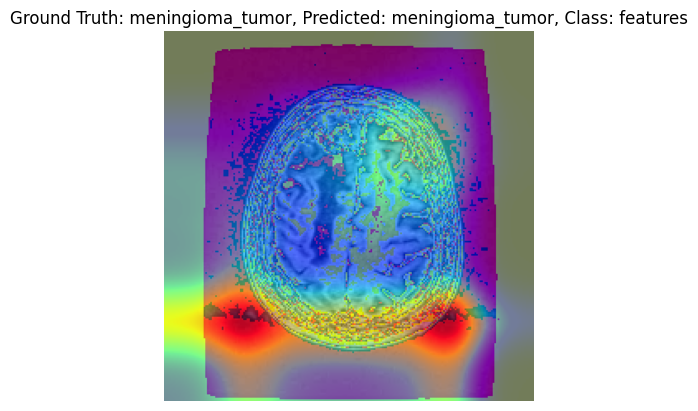

0


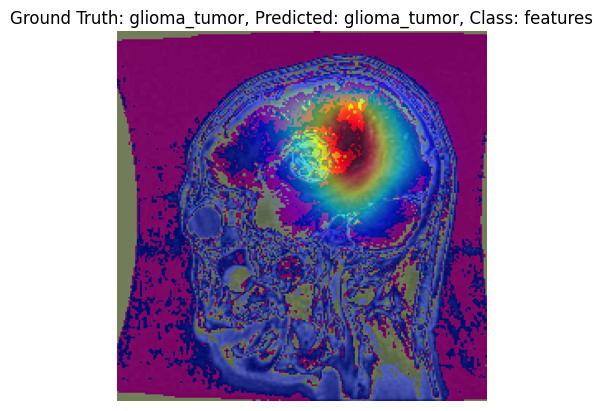

2


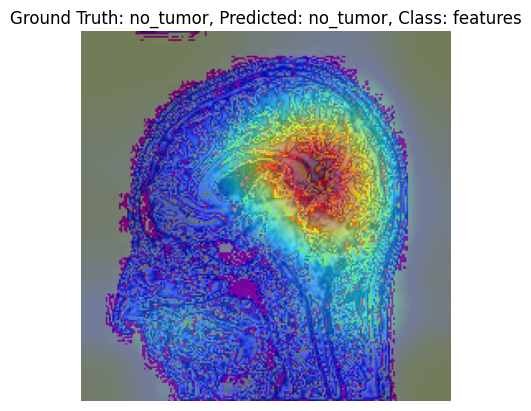

3


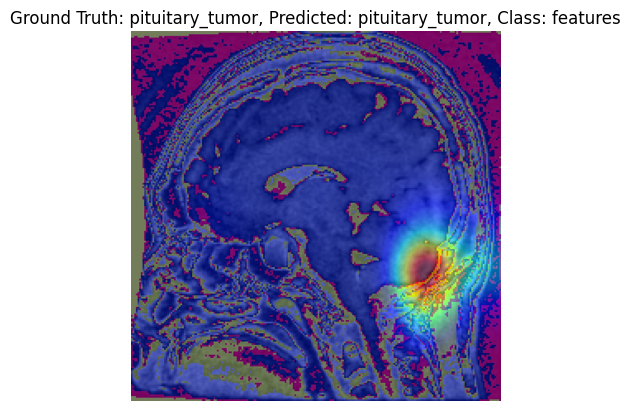

In [ ]:
# Instantiate your model here
model = torch.load('/content/drive/MyDrive/whole_data_30(mn4).pt')
model.eval()
cam_extractor = SmoothGradCAMpp(model)

# Path to the test dataset
test_dataset_path = "/content/drive/MyDrive/brain_tumor_whole/dataset/brain_tumor2/testing"
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
prefix_format = {
    "glioma_tumor": "gg ({image_number}).jpg",
    "meningioma_tumor": "m ({image_number}).jpg",
    "no_tumor":"image({image_number}).jpg",
    "pituitary_tumor":"p ({image_number}).jpg"

}

image_numbers = {

    "meningioma_tumor": [141],
    "glioma_tumor": [270],
    "no_tumor":[80],
    "pituitary_tumor": [257]

}

# Define the transformation pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to desired size
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
        std=[0.229, 0.224, 0.225]
    ),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for prefix, numbers in image_numbers.items():
    for image_number in numbers:
        # Construct the image path
        image_format = prefix_format.get(prefix, "image ({image_number}).jpg")
        image_path = f"{test_dataset_path}/{prefix}/{image_format}".replace("{image_number}", str(image_number))

        # Read and preprocess the image
        img = Image.open(image_path)
        input_tensor = preprocess(img)
        input_tensor = input_tensor.to(device)

        # Preprocess your data and feed it to the model
        out = model(input_tensor.unsqueeze(0))

        # Retrieve the CAM by passing the class index and the model output
        predicted_class = out.squeeze(0).argmax().item()
        cams = cam_extractor(predicted_class, out)

        # Get predicted class label
        predicted_label = torch.argmax(out).item()
        print(predicted_label)
        predicted_class_name = class_labels[predicted_label]

        # Display the Grad-CAM overlayed on the image along with class names
        for name, cam in zip(cam_extractor.target_names, cams):
            result = overlay_mask(to_pil_image(input_tensor.cpu()), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
            plt.imshow(result)
            plt.axis('off')
            plt.title(f"Ground Truth: {prefix}, Predicted: {predicted_class_name}, Class: {name}")
            plt.show()
